In [ ]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.python.data import Dataset
import math
from sklearn import metrics

tf.logging.set_verbosity(tf.logging.ERROR)

In [3]:
california_housing_dataframe = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_train.csv", sep=",")
california_housing_dataframe = california_housing_dataframe.reindex(np.random.permutation(california_housing_dataframe.index))

In [20]:
def preprocess_features(california_housing_dataframe):
    selected_features = california_housing_dataframe[[
        'latitude',
        'longitude',
        'housing_median_age',
        'total_rooms',
        'total_bedrooms',
        'population',
        'households',
        'median_income'
    ]]
    
    processed_features = selected_features.copy()    
    processed_features['rooms_per_person'] = (california_housing_dataframe['total_rooms'] / california_housing_dataframe['population'])
    return processed_features

def preprocess_targets(california_housing_dataframe):
    output_targets = pd.DataFrame()
    output_targets['median_house_value'] = (california_housing_dataframe['median_house_value'] / 1000.0)
    return output_targets

In [16]:
training_examples = preprocess_features(california_housing_dataframe.head(12000))
training_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000,12000.000000
mean,35.608830,-119.546607,28.587417,2637.350250,539.644250,1429.848750,500.906750,3.877773,1.970962
std,2.133952,2.011712,12.580867,2190.405818,425.442438,1164.098847,386.930036,1.916739,1.039487
min,32.540000,-124.350000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,0.018065
25%,33.930000,-121.770000,18.000000,1453.000000,296.000000,786.000000,280.000000,2.556050,1.511598
50%,34.240000,-118.470000,29.000000,2122.000000,434.000000,1165.000000,409.000000,3.531300,1.934883
75%,37.700000,-117.997500,37.000000,3145.250000,649.000000,1721.250000,605.000000,4.757625,2.293835
max,41.950000,-114.470000,52.000000,37937.000000,6445.000000,35682.000000,6082.000000,15.000100,41.333333


In [21]:
training_targets = preprocess_targets(california_housing_dataframe.head(12000))
training_targets.describe()

,median_house_value
count,12000.000000
mean,206.346363
std,115.422283
min,14.999000
25%,118.875000
50%,179.200000
75%,264.300000
max,500.001000


In [22]:
validation_examples = preprocess_features(california_housing_dataframe.tail(5000))
validation_examples.describe()

,latitude,longitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,rooms_per_person
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.000000,5000.000000,5000.000000
mean,35.664572,-119.599310,28.594000,2658.818400,538.850600,1428.91440,501.978400,3.897511,2.004915
std,2.145152,1.989077,12.602751,2154.781073,411.923773,1108.00521,378.713533,1.887517,1.433172
min,32.560000,-124.300000,1.000000,15.000000,5.000000,13.00000,4.000000,0.499900,0.119216
25%,33.940000,-121.820000,18.000000,1475.000000,299.000000,797.75000,283.000000,2.593675,1.543693
50%,34.270000,-118.560000,29.000000,2149.000000,434.000000,1170.50000,409.500000,3.571250,1.954764
75%,37.740000,-118.020000,37.000000,3166.250000,648.000000,1720.00000,606.250000,4.781300,2.306014
max,41.860000,-114.310000,52.000000,32054.000000,5290.000000,15507.00000,5050.000000,15.000100,55.222222


In [23]:
validation_targets = preprocess_targets(california_housing_dataframe.tail(5000))
validation_targets.describe()

,median_house_value
count,5000.000000
mean,209.591830
std,117.300285
min,14.999000
25%,121.175000
50%,183.000000
75%,266.700000
max,500.001000


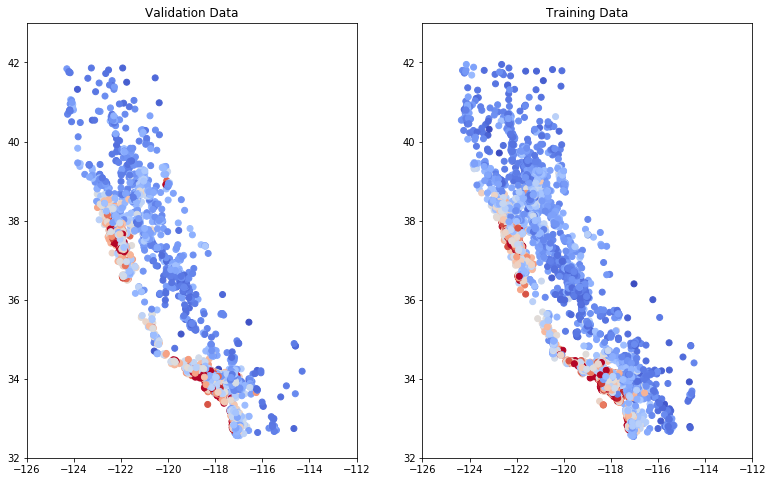

In [63]:
plt.figure(figsize=(13, 8))
ax = plt.subplot(1, 2, 1)
ax.set_title('Validation Data')
ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])

plt.scatter(validation_examples['longitude'], validation_examples['latitude'], \
            cmap='coolwarm', c=validation_targets['median_house_value'] / validation_targets['median_house_value'].max())

ax = plt.subplot(1,2,2)
ax.set_title("Training Data")

ax.set_autoscaley_on(False)
ax.set_ylim([32, 43])
ax.set_autoscalex_on(False)
ax.set_xlim([-126, -112])
plt.scatter(training_examples["longitude"],
            training_examples["latitude"],
            cmap="coolwarm",
            c=training_targets["median_house_value"] / training_targets["median_house_value"].max())

plt.show()

In [104]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    features = { key:np.array(value) for key,value in dict(features).items() }
    
    ds = Dataset.from_tensor_slices((features, targets))
    ds = ds.batch(batch_size).repeat(num_epochs)
    
    if shuffle:
        ds = ds.shuffle(10000)
    
    features, labels = ds.make_one_shot_iterator().get_next()
    return features,labels

def construct_feature_columns(input_features):
    return set([tf.feature_column.numeric_column(my_feature) for my_feature in input_features])

In [113]:
def train_model(learning_rate, steps, batch_size, training_examples, training_targets, validation_examples, validation_targets):
    periods = 10
    steps_per_period = steps / periods
    
    my_optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    linear_regressor = tf.estimator.LinearRegressor(
        feature_columns=construct_feature_columns(training_examples),
        optimizer=my_optimizer
    )
    
    
    training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, training_targets["median_house_value"], num_epochs=1, shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, validation_targets["median_house_value"], num_epochs=1, shuffle=False)
        
    print('Training model...')
    print('RMSE (on training data):')
    training_rmse = []
    validation_rmse = []
    for period in range (0, periods):
        linear_regressor.train(
            input_fn=training_input_fn,
            steps=steps_per_period
        )
        
        training_predictions = linear_regressor.predict(input_fn=predict_training_input_fn)
        training_predictions = np.array([item['predictions'][0] for item in training_predictions])
        validation_predictions = linear_regressor.predict(input_fn=predict_validation_input_fn)
        validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])
    
        training_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(training_predictions, training_targets))
        validation_root_mean_squared_error = math.sqrt(metrics.mean_squared_error(validation_predictions, validation_targets))
        
        print('period %02d : %0.2f' % (period, training_root_mean_squared_error))
        
        training_rmse.append(training_root_mean_squared_error)
        validation_rmse.append(validation_root_mean_squared_error)
        
    print('Model training finished')
    
    plt.ylabel('RMSE')
    plt.xlabel('Periods')
    plt.title('Root Mean Squared Error vs. Periods')
    plt.plot(training_rmse, label='training')
    plt.plot(validation_rmse, label='validation')
    plt.legend()
    
    return linear_regressor

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'C:\\Users\\corym\\AppData\\Local\\Temp\\tmpd8i7e0gy', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': None, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_service': None, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x00000141DD09AD30>, '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}
Training model...
RMSE (on training data):
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Savin

INFO:tensorflow:Done running local_init_op.
period 05 : 166.37
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\corym\AppData\Local\Temp\tmpd8i7e0gy\model.ckpt-300
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 301 into C:\Users\corym\AppData\Local\Temp\tmpd8i7e0gy\model.ckpt.
INFO:tensorflow:loss = 59290.08, step = 301
INFO:tensorflow:Saving checkpoints for 350 into C:\Users\corym\AppData\Local\Temp\tmpd8i7e0gy\model.ckpt.
INFO:tensorflow:Loss for final step: 60116.023.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\corym\AppData\Local\Temp\tmpd8i7e0gy\model.ckpt-350
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_o

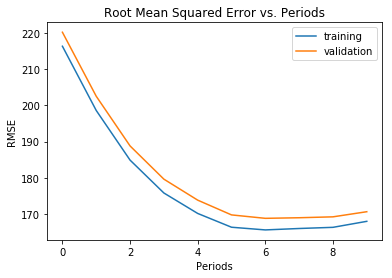

In [114]:
linear_regressor = train_model(
    learning_rate=0.00003,
    steps=500,
    batch_size=5,
    training_examples=training_examples,
    training_targets=training_targets,
    validation_examples=validation_examples,
    validation_targets=validation_targets
)

In [115]:
california_housing_test_data = pd.read_csv("https://download.mlcc.google.com/mledu-datasets/california_housing_test.csv", sep=",")

test_examples = preprocess_features(california_housing_test_data)
test_targets = preprocess_targets(california_housing_test_data)

predict_test_input_fn = lambda: my_input_fn(test_examples, test_targets['median_house_value'], num_epochs=1, shuffle=False)

test_predictions = linear_regressor.predict(input_fn=predict_test_input_fn)
print(test_predictions)
test_predictions = np.array([item['predictions'][0] for item in test_predictions])

root_mean_squared_error = math.sqrt(metrics.mean_squared_error(test_predictions, test_targets))

print('Final RMSE (on test data): %0.2f' % root_mean_squared_error)

<generator object Estimator.predict at 0x00000141DECABD58>
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from C:\Users\corym\AppData\Local\Temp\tmpd8i7e0gy\model.ckpt-500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Final RMSE (on test data): 162.11
